# Analysis - Different Number of Digits
* $A + B$
* $A$, $B$ : 3-digits, 4-digits or 5-digits interger

In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [4]:
TRAINING_SIZE = 80000
DIGITS = np.arange(3, 6)
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
ctable = CharacterTable(chars)

## Data Generation

In [5]:
questions = {}
expected = {}
for i, digits in enumerate(DIGITS):
    maxlen = MAXLEN[i]
    questions[digits] = []
    expected[digits] = []
    seen = set()
    print('Generating data of %d digits...' %digits)
    while len(questions[digits]) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (maxlen - len(q))
        ans = str(a + b)
        ans += ' ' * (digits + 1 - len(ans))
        if REVERSE:
            query = query[::-1]
        questions[digits].append(query)
        expected[digits].append(ans)
    print('Total addition questions:', len(questions[digits]))

Generating data of 3 digits...
Total addition questions: 80000
Generating data of 4 digits...
Total addition questions: 80000
Generating data of 5 digits...
Total addition questions: 80000


In [6]:
for digits in DIGITS:
    print(questions[digits][:5], expected[digits][:5])

['8+6    ', '3+98   ', '416+62 ', '14+278 ', '13+2   '] ['14  ', '101 ', '478 ', '292 ', '15  ']
['533+9    ', '586+78   ', '16+14    ', '20+5     ', '748+480  '] ['542  ', '664  ', '30   ', '25   ', '1228 ']
['7325+9     ', '78+23      ', '5066+55644 ', '71+9       ', '73033+7307 '] ['7334  ', '101   ', '60710 ', '80    ', '80340 ']


## Processing

In [7]:
x = {}
y = {}
for i, digits in enumerate(DIGITS):
    maxlen = MAXLEN[i]
    print('Vectorization of %d digits...' %digits)
    x[digits] = np.zeros((len(questions[digits]), maxlen, len(chars)), dtype=np.bool)
    y[digits] = np.zeros((len(expected[digits]), digits + 1, len(chars)), dtype=np.bool)
    for j, sentence in enumerate(questions[digits]):
        x[digits][j] = ctable.encode(sentence, maxlen)
    for j, sentence in enumerate(expected[digits]):
        y[digits][j] = ctable.encode(sentence, digits + 1)

Vectorization of 3 digits...
Vectorization of 4 digits...
Vectorization of 5 digits...


In [8]:
x_train, y_train, x_val, y_val, test_x, test_y = {}, {}, {}, {}, {}, {}
for i, digits in enumerate(DIGITS):
    indices = np.arange(len(y[digits]))
    np.random.shuffle(indices)
    x[digits] = x[digits][indices]
    y[digits] = y[digits][indices]

    # train_test_split
    train_x = x[digits][:20000]
    train_y = y[digits][:20000]
    test_x[digits] = x[digits][20000:]
    test_y[digits] = y[digits][20000:]

    split_at = len(train_x) - len(train_x) // 10
    (x_train[digits], x_val[digits]) = train_x[:split_at], train_x[split_at:]
    (y_train[digits], y_val[digits]) = train_y[:split_at], train_y[split_at:]

    print('Training Data of %d digits:' %digits)
    print(x_train[digits].shape)
    print(y_train[digits].shape)

    print('Validation Data of %d digits:' %digits)
    print(x_val[digits].shape)
    print(y_val[digits].shape)

    print('Testing Data of %d digits:' %digits)
    print(test_x[digits].shape)
    print(test_y[digits].shape)

Training Data of 3 digits:
(18000, 7, 12)
(18000, 4, 12)
Validation Data of 3 digits:
(2000, 7, 12)
(2000, 4, 12)
Testing Data of 3 digits:
(60000, 7, 12)
(60000, 4, 12)
Training Data of 4 digits:
(18000, 9, 12)
(18000, 5, 12)
Validation Data of 4 digits:
(2000, 9, 12)
(2000, 5, 12)
Testing Data of 4 digits:
(60000, 9, 12)
(60000, 5, 12)
Training Data of 5 digits:
(18000, 11, 12)
(18000, 6, 12)
Validation Data of 5 digits:
(2000, 11, 12)
(2000, 6, 12)
Testing Data of 5 digits:
(60000, 11, 12)
(60000, 6, 12)


## Build Model

In [11]:
models = {}
for i, digits in enumerate(DIGITS):
    print('Build model of %d digits...' %digits)
    maxlen = MAXLEN[i]
    model = Sequential()
    model.add(RNN(HIDDEN_SIZE, input_shape=(maxlen, len(chars))))
    model.add(layers.RepeatVector(digits + 1))
    for j in range(LAYERS):
        model.add(RNN(HIDDEN_SIZE, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    models[digits] = model

Build model of 3 digits...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Build model of 4 digits...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               72192     
________________

## Training

In [12]:
hist = {}
for digits in DIGITS:
    print('Train model of %d digits...' %digits)
    hist[digits] = models[digits].fit(x_train[digits], y_train[digits],
                                      batch_size=BATCH_SIZE,
                                      epochs=100, verbose=0,
                                      validation_data=(x_val[digits], y_val[digits]))

Train model of 3 digits...
Train model of 4 digits...
Train model of 5 digits...


## Visualization

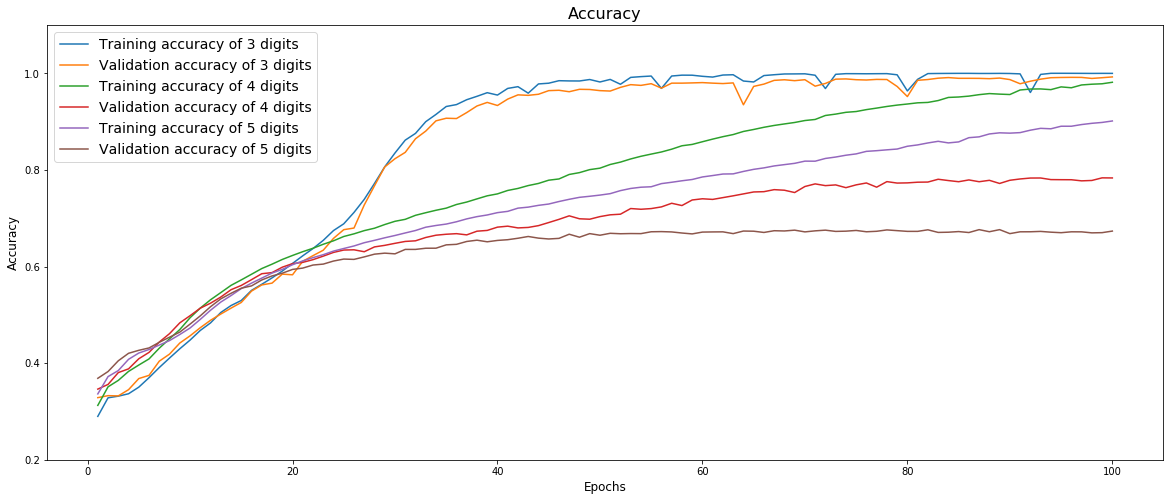

In [22]:
plt.figure(figsize=(20,8))
for digits in DIGITS:
    acc = hist[digits].history['acc']
    val_acc = hist[digits].history['val_acc']
    epochs = range(1, 101)
    plt.plot(epochs, acc, label='Training accuracy of %d digits' %digits)
    plt.plot(epochs, val_acc, label='Validation accuracy of %d digits' %digits)
plt.title('Accuracy', fontsize=16)
plt.ylim([0.2, 1.1])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=14)
plt.show()

## Testing

In [16]:
print("MSG : Prediction")
for digits in DIGITS:
    N_corr = 0
    for i in range(len(test_x[digits])):
        ind = i
        rowx, rowy = test_x[digits][np.array([ind])], test_y[digits][np.array([ind])]
        preds = models[digits].predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        if correct == guess:
            N_corr += 1
    print('Accuracy of %d digits:' %digits, N_corr / len(test_x[digits]))

MSG : Prediction
Accuracy of 3 digits: 0.9646166666666667
Accuracy of 4 digits: 0.33663333333333334
Accuracy of 5 digits: 0.10156666666666667


## Conclusion
- 隨著位數的上升，整個資料分布的空間維度也會跟著上升，導致相同大小的 traing set 所能涵蓋的資料空間比率顯著下降，accuracy 亦隨著下降。
- 也因為 traing set 所能涵蓋的資料空間比率下降，導致 overfitting 的情況更容易出現，即便我們把 training accuracy 訓練到不錯的結果，validation accuracy 可能也不會隨著上升。